In [538]:
%%capture
from numpy.random import rand

# import sys
# !{sys.executable} -m pip install --user funcy

import importlib
import policies
import config
import state_updates
import utils

importlib.reload(config)
importlib.reload(policies)
importlib.reload(state_updates)
importlib.reload(utils)

initial_conditions, rarity, market_settings = config.initial_conditions, config.rarity, config.market_settings

In [539]:
num_runs = 2

def player_active():
    awake_likelihood = 0.6  # 60% probability of player being awake
    active_likelihood = 0.3 # 30% probability of being active, given they are awake
    return rand() < (awake_likelihood*active_likelihood)

params = {
    'duration': 60, # duration of timestep (in minutes)
    'player_active': player_active
}

simulation_parameters = {
    'T': range(30),
    'N': num_runs,
    'M': params
}


initialized_conditions = utils.initialize(market_settings, initial_conditions)



# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, 
# the user specifies if state update functions will be run in series or in parallel
# and the policy functions that will be evaluated in that block
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'playerPolicy': policies.player_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            'network': state_updates.update_network,
            'bc-totalSupply': state_updates.bc_totalSupply,
            'symmetries': state_updates.update_symmetries,
            #'bc-balance': state_updates.bc_balance,
        }
    }
]

# partial_state_update_blockzzzs = [
#     miner_interactions, # miners who only take rewards and run at defined hashrates
#     player_interactions, # players who are sporadically playing, low hash rates, probabilistic buy/sell
#     market_interactions, # players who buy / sell clovers from market
#     speculators # folks speculating on clovercoin price
# ]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



from cadCAD.configuration import Configuration
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initialized_conditions.copy(), #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

from cadCAD import configs

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x7f89cbe33668>]


In [540]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import math


def to_df(raw_result):
    def flatten_cols(row):
        g = row['network']
        new_cols = {}

        
        players = utils.get_nodes_by_type(g, 'player')
        clovers = utils.get_nodes_by_type(g, 'clover')
        
        new_cols['players'] = len(players)
        new_cols['clovers'] = len(clovers)
        new_cols['bankClovers'] = len([x for x in clovers if utils.owner_type(g, x) == 'bank'])
        new_cols.update(row['symmetries'])
        # new_cols['playerClovers'] = new_cols['clovers'] = new_cols['bankClovers']
        # for clover_attr in ['hasSymmetry', 'y0Sym', 'x0Sym', 'xySym', 'xnySym', 'rotSym', 'pretty']:
        #     new_cols['net_' + clover_attr] = len([c for c in clovers if g.nodes[c][clover_attr]])

        res = {**row, **new_cols}
        res.pop('network')
        res.pop('symmetries')
        
        return res

    return pd.DataFrame(map(flatten_cols, raw_result))

df = to_df(raw_result)

# adding new useful columns for graphing
df['coin-price'] = utils.calculateCurrentPrice(
    (df['bc-totalSupply'] + market_settings['bc-virtualSupply']),
    (df['bc-balance'] + market_settings['bc-virtualBalance']),
    market_settings['bc-reserveRatio'])

df

,bankClovers,bc-balance,bc-totalSupply,clovers,hasSymmetry,players,rotSym,run,substep,timestep,x0Sym,xnySym,xySym,y0Sym,coin-price
0,0,40,30297.222283,0,0,20,0,1,0,0,0,0,0,0,0.001681
1,7,40,30317.872283,9,9,20,0,1,1,1,0,6,3,0,0.001681
2,17,40,30397.872283,25,25,20,0,1,1,2,0,17,6,1,0.001679
3,29,40,30540.372283,44,44,20,1,1,1,3,2,23,16,1,0.001678
4,35,40,30591.172283,52,52,20,2,1,1,4,2,28,17,2,0.001677
5,43,40,30616.372283,62,62,20,3,1,1,5,2,31,20,4,0.001677
6,57,40,30819.722283,82,82,20,4,1,1,6,2,42,27,4,0.001674
7,70,40,31317.722283,106,106,20,5,1,1,7,2,53,37,6,0.001668
8,88,40,31596.122283,130,130,20,6,1,1,8,6,63,45,7,0.001664
9,100,40,31889.322283,147,147,20,7,1,1,9,7,71,52,7,0.001660


In [532]:
#foo = {'me': 0}

foo['me'] += 1 if True else 0

foo['me'] += 1
foo['me']

8

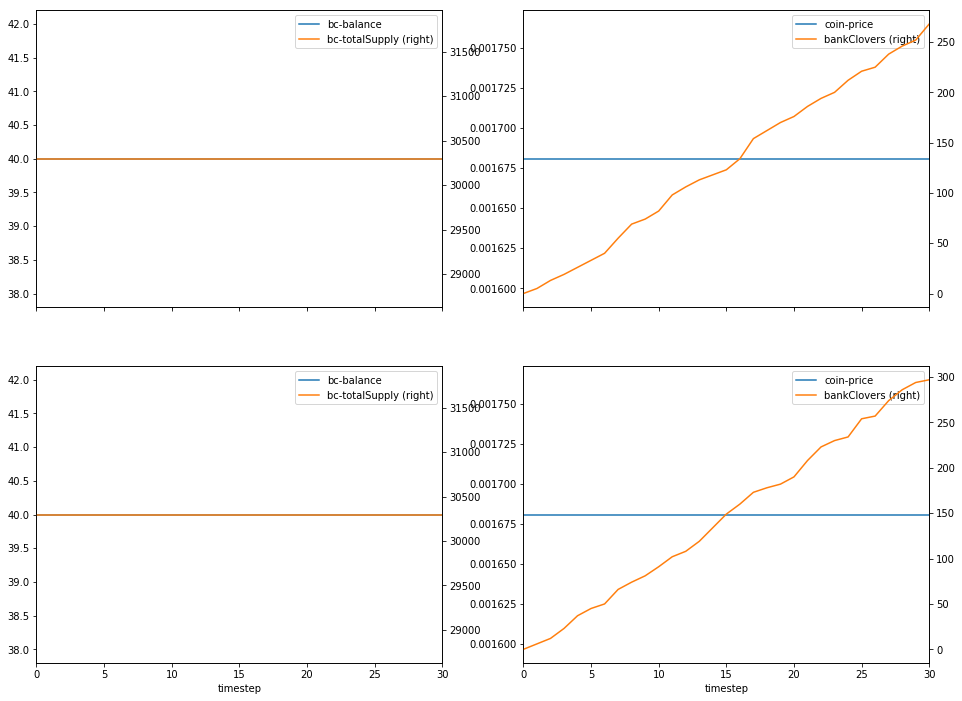

In [403]:
fig = plt.figure(figsize=(16,6*num_runs))
axs = fig.subplots(num_runs, 2)

for run in range(0,num_runs):
    df[df.run == (run+1)].plot('timestep', ['bc-balance', 'bc-totalSupply'], secondary_y=['bc-totalSupply'], ax=axs[run,0])
    df[df.run == (run+1)].plot('timestep', ['coin-price', 'bankClovers'], secondary_y=['bankClovers'], ax=axs[run,1])

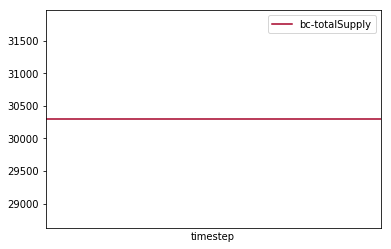

In [404]:
df_run = df[df.run == 1]
df_run.plot('timestep', ['bc-totalSupply'], grid=False, 
        xticks=[], 
        colormap = 'RdYlGn'#,
       )

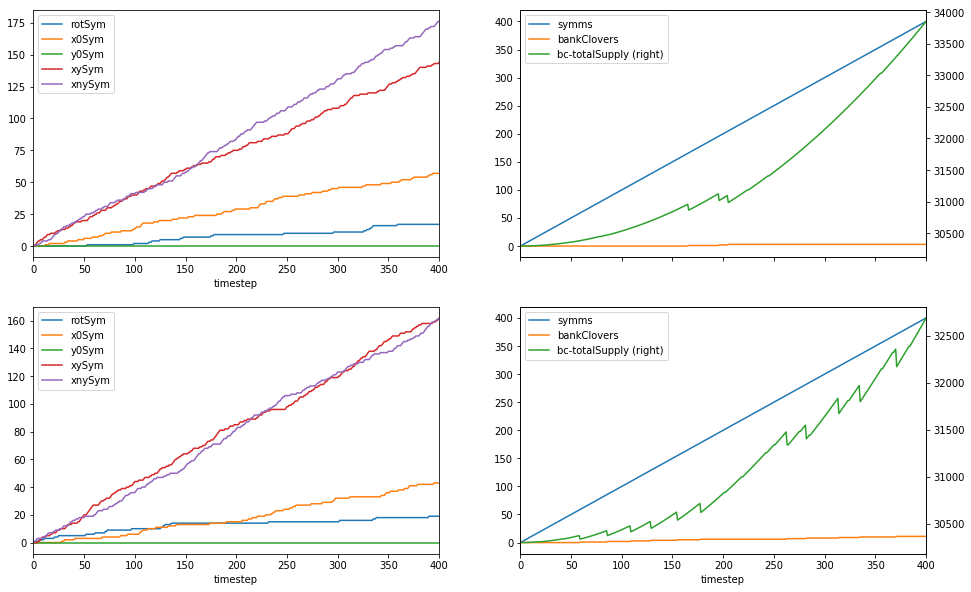

In [10]:
row_height = 5
# set a figure with initial dimensions
fig = plt.figure(figsize=(16,(row_height*num_runs)))

# create 2 axes (2 graphs) laid out in a 1x2 grid, and set them each to a variable
axs = fig.subplots(num_runs, 2)

for row_idx in range(0,num_runs):
    df_run = df[df.run == (row_idx + 1)]
    # draw out all the symmetries in a single graph, on ax1 (the left graph)
    df_run.plot('timestep', ['rotSym', 'x0Sym', 'y0Sym', 'xySym', 'xnySym'], grid=False, 
            ax=axs[row_idx,0]
           )
    
    # draw out the bank clovers and total symms on ax2 (the right graph)
    df_run.plot('timestep', ['symms','bankClovers'], ax=axs[row_idx,1])
    
    # additionally draw out the totalSupply as a secondary axis on ax2 (the right graph)
    df_run.plot('timestep','bc-totalSupply',secondary_y=True, ax=axs[row_idx,1])

In [11]:
df[df.run == 1]

,bankClovers,bc-balance,bc-totalSupply,clovers,rotSym,run,substep,symms,timestep,userClovers,x0Sym,xnySym,xySym,y0Sym,coin-price
0,0,40,30297.222283,0,0,1,0,0,0,[],0,0,0,0,0.001681
1,0,40,30297.272283,1,0,1,1,1,1,[],0,0,1,0,0.001681
2,0,40,30297.372283,2,0,1,1,2,2,[],0,1,1,0,0.001681
3,0,40,30297.522283,3,0,1,1,3,3,[],0,1,2,0,0.001681
4,0,40,30297.722283,4,0,1,1,4,4,[],0,1,3,0,0.001681
5,0,40,30297.972283,5,0,1,1,5,5,[],0,1,4,0,0.001681
6,0,40,30298.272283,6,0,1,1,6,6,[],0,2,4,0,0.001681
7,0,40,30298.622283,7,0,1,1,7,7,[],0,2,5,0,0.001681
8,0,40,30299.022283,8,0,1,1,8,8,[],0,3,5,0,0.001681
9,0,40,30299.472283,9,0,1,1,9,9,[],0,4,5,0,0.001681


In [12]:
rare_clovers = 3.6

rand() < (rare_clovers % math.floor(rand_clovers))

NameError: name 'rand_clovers' is not defined

In [13]:




rarity = {
    'rotSym':      0.000005, # 5/100 symmetrical clovers are rotational
    'y0Sym':       0.000010,  # 10/100 symmetrical clovers are y=0
    'x0Sym':       0.000010,  # 10/100 symmetrical clovers are x=0
    'xySym':       0.000040,  # 40/100 symmetrical clovers are x=y
    'xnySym':      0.000040  # 40/100 symmetrical clovers are x=-y
}



probIsRare = 1-(1-rarity['rotSym'])*(1-rarity['y0Sym'])*(1-rarity['x0Sym'])*(1-rarity['xySym'])*(1-rarity['xnySym'])


probIsRare


0.00010499620005655075

In [14]:
combinationSymmetries = utils.createCombinationRarities(rarity)

In [15]:
for k,v in combinationSymmetries.items():
    print("%s: %f" % (k,v))

('rotSym',): 0.000005
('x0Sym',): 0.000010
('y0Sym',): 0.000010
('xySym',): 0.000040
('xnySym',): 0.000040
('rotSym', 'x0Sym'): 0.000000
('rotSym', 'y0Sym'): 0.000000
('rotSym', 'xySym'): 0.000000
('rotSym', 'xnySym'): 0.000000
('x0Sym', 'y0Sym'): 0.000000
('x0Sym', 'xySym'): 0.000000
('x0Sym', 'xnySym'): 0.000000
('y0Sym', 'xySym'): 0.000000
('y0Sym', 'xnySym'): 0.000000
('xySym', 'xnySym'): 0.000000
('rotSym', 'x0Sym', 'y0Sym'): 0.000000
('rotSym', 'x0Sym', 'xySym'): 0.000000
('rotSym', 'x0Sym', 'xnySym'): 0.000000
('rotSym', 'y0Sym', 'xySym'): 0.000000
('rotSym', 'y0Sym', 'xnySym'): 0.000000
('rotSym', 'xySym', 'xnySym'): 0.000000
('x0Sym', 'y0Sym', 'xySym'): 0.000000
('x0Sym', 'y0Sym', 'xnySym'): 0.000000
('x0Sym', 'xySym', 'xnySym'): 0.000000
('y0Sym', 'xySym', 'xnySym'): 0.000000
('rotSym', 'x0Sym', 'y0Sym', 'xySym'): 0.000000
('rotSym', 'x0Sym', 'y0Sym', 'xnySym'): 0.000000
('rotSym', 'x0Sym', 'xySym', 'xnySym'): 0.000000
('rotSym', 'y0Sym', 'xySym', 'xnySym'): 0.000000
('x0Sym'

In [164]:
'%f' % (3/1000000)

'0.000003'

In [168]:
'%s %f' % ("hey", 2)

'hey 2.000000'

In [28]:
import numpy

syms = {
    'rotSym': 38,
    'x0Sym': 109,
    'xySym': 380,
    'xnySym': 442,
    'diagRotSym': 14,
    'perpRotSym': 4,
    'allSym': 4
}

totalSyms = numpy.sum(list(syms.values()))

for k,v in syms.items():
    syms[k] = v/totalSyms
    
syms

{'rotSym': 0.03834510595358224,
 'x0Sym': 0.1099899091826438,
 'xySym': 0.3834510595358224,
 'xnySym': 0.44601412714429867,
 'diagRotSym': 0.014127144298688193,
 'perpRotSym': 0.004036326942482341,
 'allSym': 0.004036326942482341}

In [81]:
rand_val = rand()

def whichSymmetry(): 
    for i in range(1,len(syms)+1):
        if rand_val <= numpy.sum(list(syms.values())[0:i]):
            break;

    list(syms.keys())[i-1]

'xnySym'

In [201]:
g = utils.initialize_network(30,5)

In [202]:

g

In [205]:
utils.get_nodes_by_type(g, "bank")[0]

35